# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [6]:
 # define your regions here
presel = {
    
        "mu": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )", 
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",   
            
            ### signal region
#             "LepIsolation": " ( (lep_pt<55) & (lep_isolation<0.15) ) | (lep_pt>=55)",
#             "LepMisolation": " ( (lep_pt>=55) & (lep_misolation<0.2) ) | (lep_pt<55)",
        },
        "ele": {
            "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#             "lep_fj_dr": "( ( lep_fj_dr<0.8) )",               
            ### signal region
#             "LepIsolation": " ( (lep_pt<120) & (lep_isolation<0.15) ) | (lep_pt>=120)",
        },
}

samples_dir = {
    "2017": "../eos/postprocessOct9_hidNeurons_2017",
    "2018": "../eos/postprocessOct5_hidNeurons_2018",
}

In [55]:
from finetuned_make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
#     "ggF", 
#     "VH",
    "VBF",
#     "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
#     "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

years = ["2017", "2016", "2016APV", "2018"]
years = ["2017", "2018"]
years = ["2018"]

events_dict = {}
events_dict["pass"] = {}
events_dict["fail"] = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region", keep_weights=True)
    events_dict["pass"] = {**events_dict["pass"], **out}
    
#     out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="qcd_region", keep_weights=True)
#     events_dict["fail"] = {**events_dict["fail"], **out}

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 401 events
INFO:root:Will fill the VBF dataframe with the remaining 401 events
INFO:root:tot event weight 52.56063750061264 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr selection on 567 events
INFO:root:Will fill the VBF dataframe with the remaining 567 events
INFO:root:tot event weight 75.79792196020279 



In [56]:
region = "pass"
for ch in ["ele", "mu"]:
    if ch == "ele":
        print("ELECTRON CHANNEL")
    else:
        print("MUON CHANNEL")


    for sample in samples:
        neg_weights = (events_dict[region][years[0]][ch][sample]["weight_mu"]<0).sum()
        tot = len(events_dict[region][years[0]][ch][sample]["weight_mu"])
        print(f"{neg_weights} out of {tot} events have negative weights for {sample}")
        
    print("----------------------------------------")        

ELECTRON CHANNEL
0 out of 401 events have negative weights for VBF
----------------------------------------
MUON CHANNEL
0 out of 567 events have negative weights for VBF
----------------------------------------


In [ ]:
ch = "ele"
year = "2018"
region = "pass"
sample = "WJetsLNu"

fig,ax = plt.subplots(figsize=(10,8))
x = "weight_ele"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label="Nominal"
)
x = "weight_ele_d1kappa_EWUp"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label=x
)
x = "weight_ele_d1kappa_EWDown"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label=x
)

if weight == f"weight_{ch}":
    ax.set_xlabel("Event weight")
else:
    ax.set_xlabel(weight)    
ax.legend(title=sample)
# ax.set_xlim(-100,100)
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
ax.set_yscale("log")
# plt.savefig(f"neg_weights/{sample}.pdf")

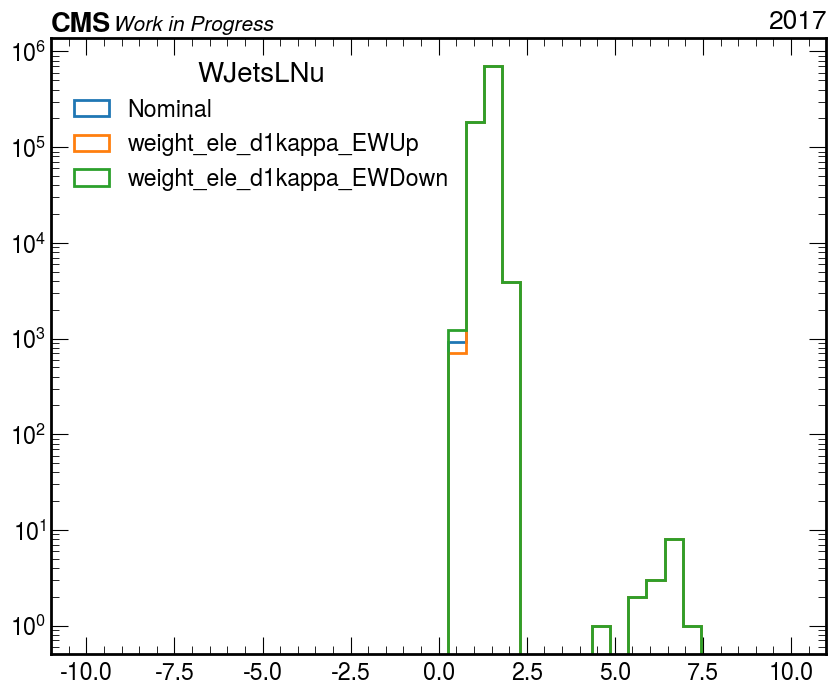

In [54]:
ch = "ele"
year = "2018"
region = "pass"
sample = "WJetsLNu"

fig,ax = plt.subplots(figsize=(10,8))
x = "weight_ele"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label="Nominal"
)
x = "weight_ele_d1kappa_EWUp"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label=x
)
x = "weight_ele_d1kappa_EWDown"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label=x
)

if weight == f"weight_{ch}":
    ax.set_xlabel("Event weight")
else:
    ax.set_xlabel(weight)    
ax.legend(title=sample)
# ax.set_xlim(-100,100)
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
ax.set_yscale("log")
# plt.savefig(f"neg_weights/{sample}.pdf")

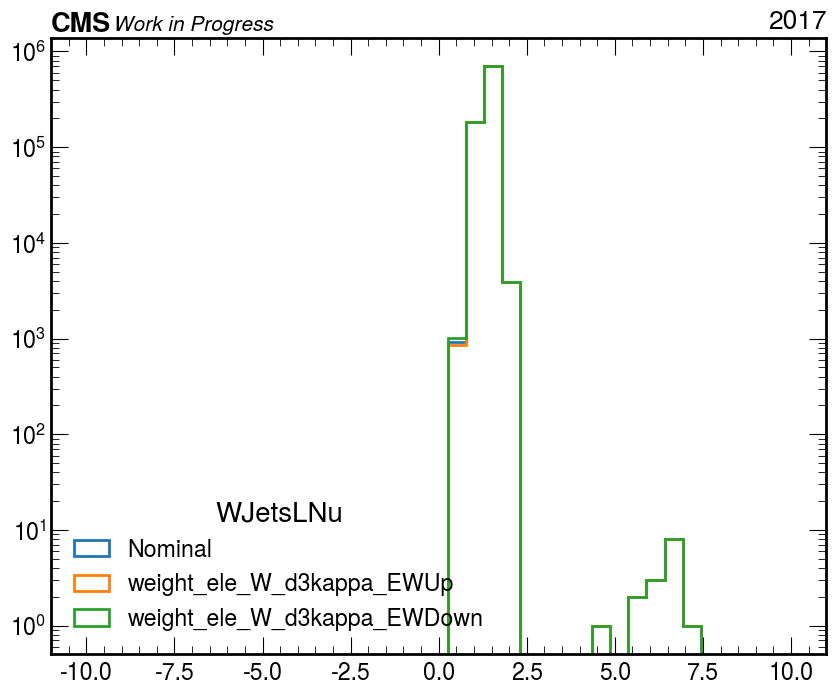

In [53]:
ch = "ele"
year = "2018"
region = "pass"
sample = "WJetsLNu"


fig,ax = plt.subplots(figsize=(10,8))
x = "weight_ele"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label="Nominal"
)
x = "weight_ele_W_d3kappa_EWUp"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label=x
)
x = "weight_ele_W_d3kappa_EWDown"
ax.hist(
    events_dict[region][year][ch][sample][x].values, 
    bins=np.linspace(-10,10,40), 
    histtype="step", 
    linewidth=2,
    label=x
)

if weight == f"weight_{ch}":
    ax.set_xlabel("Event weight")
else:
    ax.set_xlabel(weight)    
ax.legend(title=sample)
# ax.set_xlim(-100,100)
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
ax.set_yscale("log")
# plt.savefig(f"neg_weights/{sample}.pdf")

(array([3.86280e+04, 8.52842e+05, 7.74500e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 3.00000e+00, 9.00000e+00]),
 array([0.38805818, 1.07434078, 1.76062339, 2.446906  , 3.13318861,
        3.81947122, 4.50575383, 5.19203644, 5.87831904, 6.56460165,
        7.25088426]),
 <BarContainer object of 10 artists>)

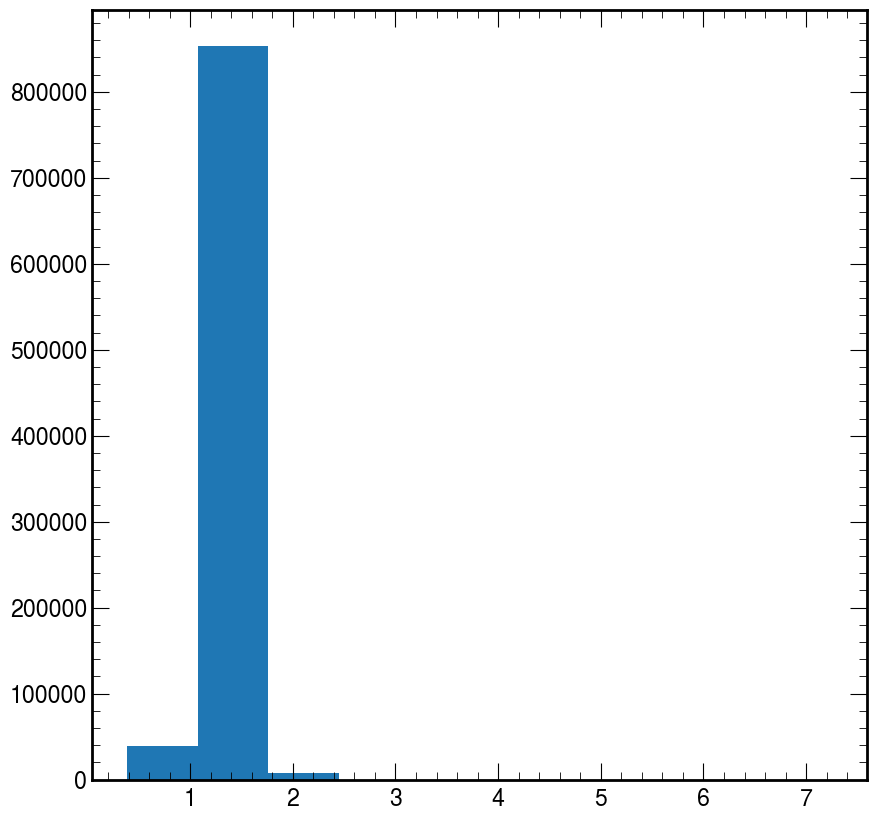

In [51]:
plt.hist(events_dict[region][year][ch][sample]["weight_ele_W_d3kappa_EWUp"].values)

In [63]:
(events_dict["2017"]["mu"]["ggF"]["weight_mu_trigger_iso_muonUp"]<0).sum()

5

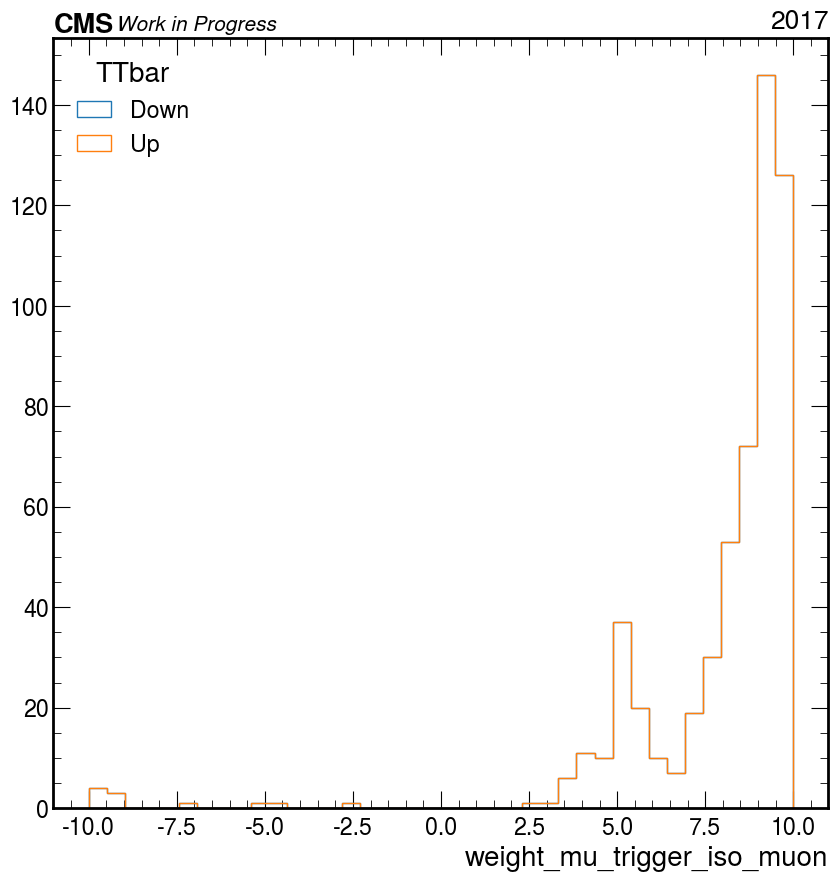

In [75]:
sample = "TTbar"
fig,ax = plt.subplots()
ax.hist(events_dict["2017"]["mu"][sample]["weight_mu"].values, bins=np.linspace(-10,10,40), histtype="step", label="Down")
ax.hist(events_dict["2017"]["mu"][sample]["weight_mu"].values, bins=np.linspace(-10,10,40), histtype="step", label="Up")
ax.set_xlabel("weight_mu_trigger_iso_muon")
ax.legend(title=sample)
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

# ax.set_xlim(-100,100)

(array([9.00000e+00, 1.00000e+00, 1.00000e+00, 9.00000e+00, 4.45413e+05,
        1.61140e+04, 1.00000e+00, 1.00000e+00, 6.00000e+00, 2.00000e+01]),
 array([-102800.78248683,  -81854.22114843,  -60907.65981004,
         -39961.09847164,  -19014.53713324,    1932.02420516,
          22878.58554355,   43825.14688195,   64771.70822035,
          85718.26955875,  106664.83089715]),
 <BarContainer object of 10 artists>)

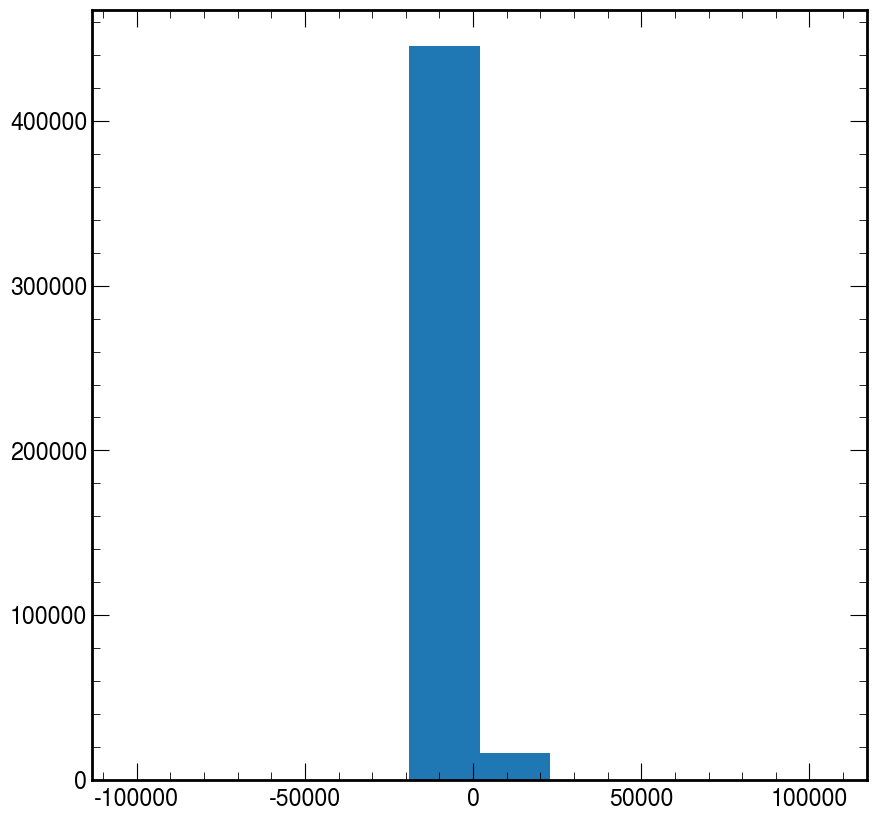

In [27]:
plt.hist(events_dict["2017"]["mu"]["DYJets"]["weight_mu_trigger_iso_muonDown"].values)

In [9]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [26]:
events_dict["2017"]["mu"].keys()

In [8]:
samples

['HWW',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson']

In [11]:
print("MUON CHANNEL")
mu_weights = []
for key in events_dict["2017"]["mu"]["WJetsLNu"].keys():
    if "weight_mu" in key and "Down" in key:
        print(key[:-4])
        mu_weights.append(key[:-4])
        
# print("ELECTRON CHANNEL")
# ele_weights = []
# for key in events_dict["2017"]["ele"]["WJetsLNu"].keys():
#     if "weight_ele" in key and "Down" in key:
#         print(key[:-4])
#         ele_weights.append(key[:-4])        

MUON CHANNEL
weight_mu_btagSFlight_correlated
weight_mu_isolation_muon
weight_mu_L1Prefiring
weight_mu_trigger_iso_muon
weight_mu_btagSFbc_correlated
weight_mu_d2K_NLO
weight_mu_btagSFlight_2017
weight_mu_W_d2kappa_EW
weight_mu_d1kappa_EW
weight_mu_W_d3kappa_EW
weight_mu_trigger_noniso_muon
weight_mu_btagSFbc_2017
weight_mu_id_muon
weight_mu_pileup
weight_mu_d1K_NLO
weight_mu_d3K_NLO


In [12]:
print("# of events with negative weights:")
for ch in ["mu", "ele"]:

    for year in years:
        for sample in samples:

            df = events_dict[year][ch][sample]

            print(ch, "channel", sample, (df[f"weight_{ch}"]<0).sum(), "out of", len(df[f"weight_{ch}"]), "events")

# of events with negative weights:
mu channel HWW 5 out of 17893 events
mu channel VH 1115 out of 62625 events
mu channel VBF 5 out of 1426 events
mu channel ttH 243 out of 10498 events
mu channel QCD 0 out of 8011 events
mu channel DYJets 143116 out of 461575 events
mu channel WJetsLNu 0 out of 984861 events
mu channel WZQQ 0 out of 4478 events
mu channel TTbar 15811 out of 1524322 events
mu channel SingleTop 18429 out of 185681 events
mu channel Diboson 0 out of 15726 events
ele channel HWW 2 out of 12596 events
ele channel VH 835 out of 49317 events
ele channel VBF 0 out of 921 events
ele channel ttH 229 out of 11238 events
ele channel QCD 0 out of 15660 events
ele channel DYJets 420496 out of 1392310 events
ele channel WJetsLNu 0 out of 732875 events
ele channel WZQQ 0 out of 7123 events
ele channel TTbar 16423 out of 1565946 events
ele channel SingleTop 12638 out of 131504 events
ele channel Diboson 0 out of 31358 events


In [10]:
events_dict[year][ch][sample]["lol"]

0       0.216724
6       0.216724
11      0.216724
21      0.216724
23      0.216724
          ...   
7706    0.145006
7711    0.145006
7714    0.145006
7715    0.145006
7723    0.145006
Name: lol, Length: 31358, dtype: float64

In [90]:
plt.rcParams.update({"font.size": 20})

ch = "ele"
var = "weight_mu_pileup"


# make histogram
h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),    
    hist2.axis.Regular(60, 0, 1, name="sys", label=var, overflow=True),
    hist2.axis.StrCategory([], name="variation", growth=True),
)    

for year in years:
    for sample in samples:

        if f"{var}Down" not in events_dict[year][ch][sample].keys():
            continue

        df = events_dict[year][ch][sample]

        h.fill(
            samples=sample,
            sys=df[f"{var}Down"],
            variation="Down"
        )

        h.fill(
            samples=sample,
            sys=df[f"{var}Up"],
            variation="Up"
        )        

        h.fill(
            samples=sample,
            sys=df[f"weight_mu"],
            variation="Nominal"
        )

sum of up counts: {}


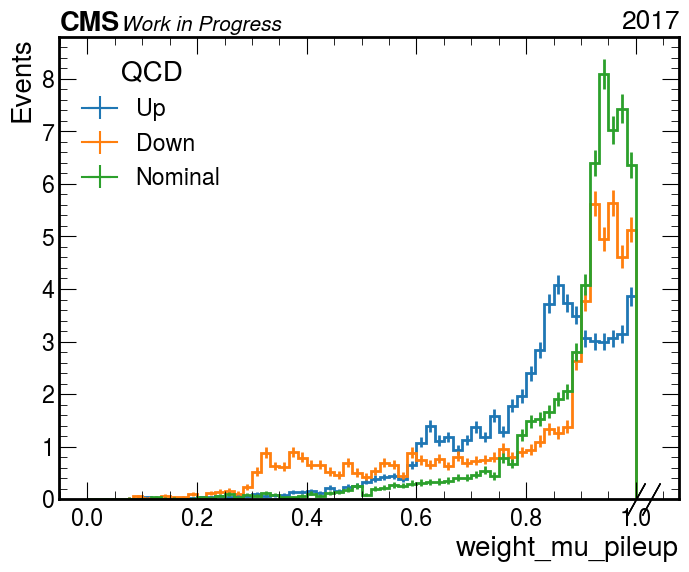

In [91]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

sample = "HWW"
sample = "QCD"
# sample = "WJetsLNu"
# sample = "TTbar"
# sample = "DYJets"

for variation in ["Up", "Down", "Nominal"]:
    
    if sample=="all":
        hep.histplot(
            h[{"samples": sum, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

    else:
        hep.histplot(
            h[{"samples": sample, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

ax.legend() 
if sample != "all":
    ax.legend(title=sample)

ax.set_ylabel("Events")
plt.xlabel = var
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics/{var}_{sample}.pdf")


print("sum of up counts: {}")

In [83]:
h[{"samples": "DYJets", "variation": "Up"}].counts()

array([ 1697.,  1711.,  1698.,  1494.,  1437.,  1383.,  1328.,  1264.,
        1279.,  1306.,  1301.,  1241.,  1245.,  1103.,  1099.,   980.,
         983.,   891.,   887.,  1089.,  3041.,  5030.,  8628.,  8362.,
        5755.,  2951.,  1343.,  1121.,  2140., 30562., 79677.,  5108.,
        2625.,  3206.,  7455., 14133., 20563., 20851., 12151.,  7205.,
        2622.,  2032.,  1967.,  2218.,  2246.,  2503.,  2501.,  2734.,
        2886.,  2937.,  2905.,  2879.,  2811.,  3010.,  3170.,  3228.,
        3452.,  3650.,  3841.,  3798.])

In [84]:
            hep.histplot(
                h[{"samples": sample, "variation": variation}],
                ax=ax,
                label=variation,
                linewidth=2,
                density=True
            )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x2dfdf6e20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

In [ ]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

sample = "HWW"
# sample = "QCD"
# sample = "WJetsLNu"
# sample = "TTbar"

for variation in ["Up", "Down", "Nominal"]:
    
    if sample=="all":
        hep.histplot(
            h[{"samples": sum, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

    else:
        hep.histplot(
            h[{"samples": sample, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

ax.legend() 
if sample != "all":
    ax.legend(title=sample)

ax.set_ylabel("Events")
plt.xlabel = var
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics/{var}_{sample}.pdf")

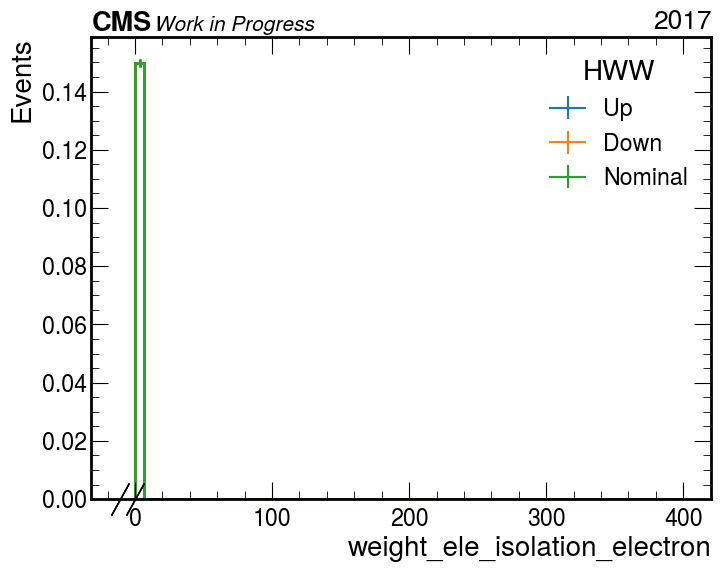

In [13]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))

sample = "all"
sample = "HWW"
# sample = "QCD"
# sample = "WJetsLNu"
# sample = "TTbar"

for variation in ["Up", "Down", "Nominal"]:
    
    if sample=="all":
        hep.histplot(
            h[{"samples": sum, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

    else:
        hep.histplot(
            h[{"samples": sample, "variation": variation}],
            ax=ax,
            label=variation,
            linewidth=2,
            density=True
        )

ax.legend() 
if sample != "all":
    ax.legend(title=sample)

ax.set_ylabel("Events")
plt.xlabel = var
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics/{var}_{sample}.pdf")

# rec_higgs_m

In [630]:
print("MUON CHANNEL")
mu_weights = []
for key in events_dict["2017"]["mu"]["HWW"].keys():
    if "weight_mu" in key and "Down" in key:
        print(key[:-4])
        mu_weights.append(key[:-4])
        
# print("ELECTRON CHANNEL")
# ele_weights = []
# for key in events_dict["2017"]["ele"]["WJetsLNu"].keys():
#     if "weight_ele" in key and "Down" in key:
#         print(key[:-4])
#         ele_weights.append(key[:-4])        

MUON CHANNEL
weight_mu_btagSFbc_2017
weight_mu_pileup
weight_mu_PDFaS_weight
weight_mu_btagSFbc_correlated
weight_mu_trigger_iso_muon
weight_mu_UEPS_ISR
weight_mu_btagSFlight_2017
weight_mu_id_muon
weight_mu_UEPS_FSR
weight_mu_scalevar_3pt
weight_mu_L1Prefiring
weight_mu_isolation_muon
weight_mu_btagSFlight_correlated
weight_mu_aS_weight
weight_mu_trigger_noniso_muon
weight_mu_scalevar_7pt
weight_mu_PDF_weight


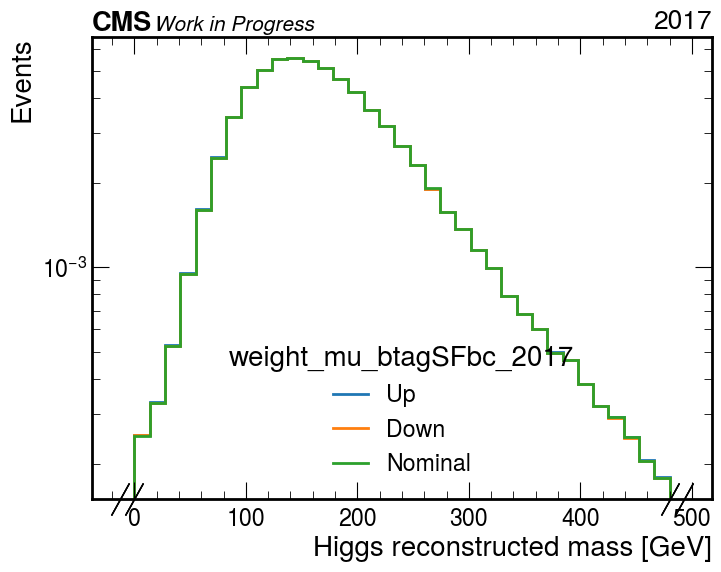

In [27]:
plt.rcParams.update({"font.size": 20})

var = "weight_mu_btagSFbc_2017"

# make histogram
h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    hist2.axis.StrCategory([], name="variation", growth=True),    
    hist2.axis.Regular(35, 0, 480, name="mass", label=r"Higgs reconstructed mass [GeV]", overflow=True)
)    

for year in years:
    for ch in ["mu"]:
        for sample in samples:
            
            if f"{var}Down" not in events_dict[year][ch][sample].keys():
                continue
            
            df = events_dict[year][ch][sample]

            h.fill(
                samples=sample,
                variation="Up",
                mass=df["rec_higgs_m"],
                weight=df[f"{var}Up"],
            )

            h.fill(
                samples=sample,
                variation="Down",
                mass=df["rec_higgs_m"],
                weight=df[f"{var}Down"],
            )

            h.fill(
                samples=sample,
                variation="Nominal",
                mass=df["rec_higgs_m"],
                weight=df[f"weight_{ch}"],
            )
            
# plot histogram




# for sample in ["HWW", "QCD", "WJetsLNu", "TTbar"]:
for sample in ["WJetsLNu"]:
    sample = "all"
    
    fig, ax = plt.subplots(figsize=(8, 6))    
    
    for variation in ["Up", "Down", "Nominal"]:

        if sample=="all":
            hep.histplot(
                h[{"samples": sum, "variation": variation}],
                ax=ax,
                label=variation,
                linewidth=2,
                density=True
            )

        else:
            hep.histplot(
                h[{"samples": sample, "variation": variation}],
                ax=ax,
                label=variation,
                linewidth=2,
                density=True
            )

    ax.legend(title=var) 
    if sample == "all":
        ax.legend(title=var)
        hep.cms.lumitext(
            "2017", ax=ax, fontsize=20
        )
    else:
        hep.cms.lumitext(
            sample + " - 2017", ax=ax, fontsize=20
        )      

    ax.set_ylabel("Events")
    plt.xlabel = var

    hep.cms.text("Work in Progress", ax=ax, fontsize=15);
    ax.set_yscale("log")
    plt.savefig(f"/Users/fmokhtar/Desktop/hww/systematics_v2/{var}.pdf")            

# Envelope

In [618]:
def shape_to_num(var, nom, clip=1.5):
    nom_rate = np.sum(nom)
    var_rate = np.sum(var)

    if abs(var_rate/nom_rate) > clip:
        var_rate = clip*nom_rate

    if var_rate < 0:
        var_rate = 0

    return var_rate/nom_rate

In [659]:
year = "2017"

weights = {
    
    "mu": {
        "all": [
            "weight_mu_btagSFlight_2017",
            "weight_mu_btagSFlight_correlated",
            "weight_mu_btagSFbc_2017",
            "weight_mu_btagSFbc_correlated",
            "weight_mu_pileup",
            "weight_mu_isolation_muon",
            "weight_mu_id_muon",
            "weight_mu_L1Prefiring",
            "weight_mu_trigger_iso_muon",
            "weight_mu_trigger_noniso_muon",            
        ],
        "WJetsLNu": [
            "weight_mu_d1K_NLO",
            "weight_mu_d2K_NLO",
            "weight_mu_d3K_NLO",
            "weight_mu_d1kappa_EW",
            "weight_mu_W_d2kappa_EW",
            "weight_mu_W_d3kappa_EW"
        ],
        "HWW": [
            "weight_mu_UEPS_FSR",
            "weight_mu_UEPS_ISR",
            "weight_mu_PDF_weight",
            "weight_mu_PDFaS_weight",
            "weight_mu_scalevar_3pt",
            "weight_mu_scalevar_7pt"
        ]
    },
    
    "ele": {
        "all": [
            "weight_ele_btagSFlight_2017",
            "weight_ele_btagSFlight_correlated",
            "weight_ele_btagSFbc_2017",
            "weight_ele_btagSFbc_correlated",
            "weight_ele_pileup",
            "weight_ele_isolation_electron",
            "weight_ele_id_electron",
            "weight_ele_L1Prefiring",
            "weight_ele_trigger_electron",
            "weight_ele_reco_electron"
        ],
        "WJetsLNu": [
            "weight_ele_d1K_NLO",
            "weight_ele_d2K_NLO",
            "weight_ele_d3K_NLO",
            "weight_ele_d1kappa_EW",
            "weight_ele_W_d2kappa_EW",
            "weight_ele_W_d3kappa_EW"
        ],
        "HWW": [
            "weight_ele_UEPS_FSR",
            "weight_ele_UEPS_ISR",
            "weight_ele_PDF_weight",
            "weight_ele_PDFaS_weight",
            "weight_ele_scalevar_3pt",
            "weight_ele_scalevar_7pt"
        ]
    },
}

In [774]:
norm_systematics = {
    "mu": [
            "weight_mu_btagSFlight_2017",
            "weight_mu_btagSFlight_correlated",
            "weight_mu_btagSFbc_2017",
            "weight_mu_btagSFbc_correlated",
            "weight_mu_isolation_muon",
            "weight_mu_id_muon",
            "weight_mu_L1Prefiring",
            "weight_mu_trigger_iso_muon",
            "weight_mu_trigger_noniso_muon",         
    ],
    "ele": [
            "weight_ele_btagSFlight_2017",
            "weight_ele_btagSFlight_correlated",
            "weight_ele_btagSFbc_2017",
            "weight_ele_btagSFbc_correlated",
            "weight_ele_isolation_electron",
            "weight_ele_id_electron",
            "weight_ele_L1Prefiring",
            "weight_ele_trigger_electron",
            "weight_ele_reco_electron"        
    ]
}

# MUON channel

In [748]:
import pickle as pkl
with open("/Users/fmokhtar/Desktop/hww/test/hists_templates.pkl", "rb") as f:
    hists_templates = pkl.load(f)

In [749]:
hists_templates

{'cat1_sr': Hist(
   StrCategory(['WJetsLNu', 'TTbar', 'HWW', 'QCD', 'Data'], growth=True, name='samples'),
   StrCategory(['Nominal', 'weight_mu_btagSFlight_2017Up', 'weight_mu_btagSFlight_2017Down', 'weight_mu_btagSFlight_correlatedUp', 'weight_mu_btagSFlight_correlatedDown', 'weight_mu_btagSFbc_2017Up', 'weight_mu_btagSFbc_2017Down', 'weight_mu_btagSFbc_correlatedUp', 'weight_mu_btagSFbc_correlatedDown', 'weight_mu_pileupUp', 'weight_mu_pileupDown', 'weight_mu_isolation_muonUp', 'weight_mu_isolation_muonDown', 'weight_mu_id_muonUp', 'weight_mu_id_muonDown', 'weight_mu_L1PrefiringUp', 'weight_mu_L1PrefiringDown', 'weight_mu_trigger_iso_muonUp', 'weight_mu_trigger_iso_muonDown', 'weight_mu_trigger_noniso_muonUp', 'weight_mu_trigger_noniso_muonDown', 'weight_mu_d1K_NLOUp', 'weight_mu_d1K_NLODown', 'weight_mu_d2K_NLOUp', 'weight_mu_d2K_NLODown', 'weight_mu_d3K_NLOUp', 'weight_mu_d3K_NLODown', 'weight_mu_d1kappa_EWUp', 'weight_mu_d1kappa_EWDown', 'weight_mu_W_d2kappa_EWUp', 'weight_mu_W_

In [751]:
for weight
hists_templates["cat1_sr"][{"samples": "TTbar", "fj_pt":sum, "systematic": "Nominal"}]

Hist(Variable([40, 61, 82, 103, 124, 145, 166, 187, 208, 229], name='rec_higgs_m', label='Higgs reconstructed mass [GeV]'), storage=Double()) # Sum: 8269085.147252883 (12288173.194868485 with flow)

In [788]:
norm_systematics_json = {}

ch = "mu"
for systematic in hists_templates["cat1_sr"].axes[1]:
    
    if "Up" in systematic:
        if systematic[:-2] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")
            
            norm_systematics_json[systematic] = norm        

    elif "Down" in systematic:
        if systematic[:-4] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")
            
            norm_systematics_json[systematic] = norm        

weight_mu_btagSFlight_2017Up: 1.0074279134165776
weight_mu_btagSFlight_2017Down: 0.9870638141541913
weight_mu_btagSFlight_correlatedUp: 1.0059360155274204
weight_mu_btagSFlight_correlatedDown: 0.9885730035614435
weight_mu_btagSFbc_2017Up: 1.0084557568927446
weight_mu_btagSFbc_2017Down: 0.9853050986973829
weight_mu_btagSFbc_correlatedUp: 1.0051590943758406
weight_mu_btagSFbc_correlatedDown: 0.9890074107614317
weight_mu_isolation_muonUp: 0.9969001548323311
weight_mu_isolation_muonDown: 0.9966775409589836
weight_mu_id_muonUp: 0.997743672920469
weight_mu_id_muonDown: 0.9958340228708451
weight_mu_L1PrefiringUp: 0.9879580087174192
weight_mu_L1PrefiringDown: 1.0055953315321364
weight_mu_trigger_iso_muonUp: 0.9969059771670048
weight_mu_trigger_iso_muonDown: 0.99667171862431
weight_mu_trigger_noniso_muonUp: 0.9978654520573604
weight_mu_trigger_noniso_muonDown: 0.9957122437339533


In [789]:
norm_systematics_json

{'weight_mu_btagSFlight_2017Up': 1.0074279134165776,
 'weight_mu_btagSFlight_2017Down': 0.9870638141541913,
 'weight_mu_btagSFlight_correlatedUp': 1.0059360155274204,
 'weight_mu_btagSFlight_correlatedDown': 0.9885730035614435,
 'weight_mu_btagSFbc_2017Up': 1.0084557568927446,
 'weight_mu_btagSFbc_2017Down': 0.9853050986973829,
 'weight_mu_btagSFbc_correlatedUp': 1.0051590943758406,
 'weight_mu_btagSFbc_correlatedDown': 0.9890074107614317,
 'weight_mu_isolation_muonUp': 0.9969001548323311,
 'weight_mu_isolation_muonDown': 0.9966775409589836,
 'weight_mu_id_muonUp': 0.997743672920469,
 'weight_mu_id_muonDown': 0.9958340228708451,
 'weight_mu_L1PrefiringUp': 0.9879580087174192,
 'weight_mu_L1PrefiringDown': 1.0055953315321364,
 'weight_mu_trigger_iso_muonUp': 0.9969059771670048,
 'weight_mu_trigger_iso_muonDown': 0.99667171862431,
 'weight_mu_trigger_noniso_muonUp': 0.9978654520573604,
 'weight_mu_trigger_noniso_muonDown': 0.9957122437339533}

In [790]:
import json
with open('mu_norm_systematics.json', 'w') as fp:
    json.dump(norm_systematics_json, fp)

In [791]:
! ls 

Feb7_build_tagger_inputs.ipynb         gen_matching_deep.ipynb
Feb7_matching_functions.ipynb          ggF_exploration.ipynb
Jul21_btag.ipynb                       ggh.root
Jul21_btagSF.ipynb                     hists_plots.ipynb
Jul21_rhalphalib.ipynb                 merged_file.root
Jul25_make_cards.ipynb                 mini-isolation.ipynb
July6_VBF_exploration.ipynb            mu_norm_systematics.json
July6_hists_plots_zll.ipynb            new.root
July6_regressed_mass.ipynb             old
July6_s_over_b.ipynb                   outfiles
July6_weights.ipynb                    outfiles2
June29_gen_matching.ipynb              processors.zip
README.md                              roc_curves.ipynb
Untitled.ipynb                         trigger_efficiency_plots.ipynb
check_signal_tth.ipynb                 trigger_efficiency_scale_factors.ipynb
coffea_playground.ipynb                triton_check.ipynb
cutflows.ipynb                         tt_matching_inference.ipynb
efficiencies        

In [785]:
ch = "ele"
for systematic in hists_templates["cat1_sr"].axes[1]:
    
    if "Up" in systematic:
        if systematic[:-2] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")
    
    elif "Down" in systematic:
        if systematic[:-4] in norm_systematics[ch]:
            norm = shape_to_num(
                var=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": systematic}].values(), 
                nom=hists_templates["cat1_sr"][{"samples": sum, "fj_pt":sum, "systematic": "Nominal"}].values()
            )    
            print(f"{systematic}: {norm}")    